[RMSProp](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) (for Root Mean Square Propagation) is also a method in which the learning rate is adapted for each of the parameters. The idea is to divide the learning rate for a weight by a running average of the magnitudes of recent gradients for that weight. So, first the running average is calculated in terms of means square,

\begin{align}
\ v(w,t) := \gamma v(w, t-1)+(1-\gamma)(\bigtriangledown Q_i(w))^2
\end{align}

where gamma is the forgetting factor.

The parameters are updates as,

\begin{align}
\ w := w - \frac{\eta}{\sqrt{v(w,t)}}\bigtriangledown Q_i(w)
\end{align}

Or, in pseudo-code:  
`cache = decay_rate*cache + (1 - decay_rate)*gradient^2  
w -= learning_rate*gradient / (sqrt(cache) + epsilon)  
`

In [1]:
# Compare RMSprop vs. constant learning rate

import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import os
os.chdir('ann_class2')

from util import get_normalized_data, error_rate, cost, y2indicator
from mlp import forward, derivative_w2, derivative_w1, derivative_b2, derivative_b1

In [2]:
max_iter = 20 # make it 30 for sigmoid
print_period = 10

X, Y = get_normalized_data()
lr = 0.00004
reg = 0.01

Xtrain = X[:-1000,]
Ytrain = Y[:-1000]
Xtest  = X[-1000:,]
Ytest  = Y[-1000:]
Ytrain_ind = y2indicator(Ytrain)
Ytest_ind = y2indicator(Ytest)

N, D = Xtrain.shape
batch_sz = 500
n_batches = N / batch_sz

M = 300
K = 10
W1 = np.random.randn(D, M) / 28
b1 = np.zeros(M)
W2 = np.random.randn(M, K) / np.sqrt(M)
b2 = np.zeros(K)

Reading in and transforming data...


In [7]:
# 1. const
# cost = -16
LL_batch = []
CR_batch = []
for i in range(int(max_iter)):
    for j in range(int(n_batches)):
        Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
        Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]
        pYbatch, Z = forward(Xbatch, W1, b1, W2, b2)
        # print "first batch cost:", cost(pYbatch, Ybatch)

        # updates
        W2 -= lr*(derivative_w2(Z, Ybatch, pYbatch) + reg*W2)
        b2 -= lr*(derivative_b2(Ybatch, pYbatch) + reg*b2)
        W1 -= lr*(derivative_w1(Xbatch, Z, Ybatch, pYbatch, W2) + reg*W1)
        b1 -= lr*(derivative_b1(Z, Ybatch, pYbatch, W2) + reg*b1)

        if j % print_period == 0:
            # calculate just for LL
            pY, _ = forward(Xtest, W1, b1, W2, b2)
            # print "pY:", pY
            ll = cost(pY, Ytest_ind)
            LL_batch.append(ll)
            print("Cost at iteration i=%d, j=%d: %.6f" % (i, j, ll))

            err = error_rate(pY, Ytest)
            CR_batch.append(err)
            print("Error rate:", err)

pY, _ = forward(Xtest, W1, b1, W2, b2)
print("Final error rate:", error_rate(pY, Ytest))

Cost at iteration i=0, j=0: 2434.262868
Error rate: 0.861
Cost at iteration i=0, j=10: 1807.042686
Error rate: 0.497
Cost at iteration i=0, j=20: 1445.374898
Error rate: 0.36
Cost at iteration i=0, j=30: 1223.380808
Error rate: 0.286
Cost at iteration i=0, j=40: 1069.282351
Error rate: 0.25
Cost at iteration i=0, j=50: 958.754135
Error rate: 0.224
Cost at iteration i=0, j=60: 869.468569
Error rate: 0.198
Cost at iteration i=0, j=70: 802.944080
Error rate: 0.174
Cost at iteration i=0, j=80: 747.176128
Error rate: 0.162
Cost at iteration i=1, j=0: 737.288393
Error rate: 0.16
Cost at iteration i=1, j=10: 693.949347
Error rate: 0.151
Cost at iteration i=1, j=20: 657.651072
Error rate: 0.147
Cost at iteration i=1, j=30: 627.508180
Error rate: 0.14
Cost at iteration i=1, j=40: 602.486021
Error rate: 0.136
Cost at iteration i=1, j=50: 581.306484
Error rate: 0.132
Cost at iteration i=1, j=60: 559.115094
Error rate: 0.13
Cost at iteration i=1, j=70: 541.978565
Error rate: 0.126
Cost at iteratio

In [9]:
# 2. RMSprop
W1 = np.random.randn(D, M) / 28
b1 = np.zeros(M)
W2 = np.random.randn(M, K) / np.sqrt(M)
b2 = np.zeros(K)
LL_rms = []
CR_rms = []
lr0 = 0.001 # if you set this too high you'll get NaN!
cache_W2 = 0
cache_b2 = 0
cache_W1 = 0
cache_b1 = 0
decay_rate = 0.999
eps = 0.0000000001
for i in range(int(max_iter)):
    for j in range(int(n_batches)):
        Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
        Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]
        pYbatch, Z = forward(Xbatch, W1, b1, W2, b2)
        # print "first batch cost:", cost(pYbatch, Ybatch)

        # updates
        gW2 = derivative_w2(Z, Ybatch, pYbatch) + reg*W2
        cache_W2 = decay_rate*cache_W2 + (1 - decay_rate)*gW2*gW2
        W2 -= lr0 * gW2 / (np.sqrt(cache_W2) + eps)

        gb2 = derivative_b2(Ybatch, pYbatch) + reg*b2
        cache_b2 = decay_rate*cache_b2 + (1 - decay_rate)*gb2*gb2
        b2 -= lr0 * gb2 / (np.sqrt(cache_b2) + eps)

        gW1 = derivative_w1(Xbatch, Z, Ybatch, pYbatch, W2) + reg*W1
        cache_W1 = decay_rate*cache_W1 + (1 - decay_rate)*gW1*gW1
        W1 -= lr0 * gW1 / (np.sqrt(cache_W1) + eps)

        gb1 = derivative_b1(Z, Ybatch, pYbatch, W2) + reg*b1
        cache_b1 = decay_rate*cache_b1 + (1 - decay_rate)*gb1*gb1
        b1 -= lr0 * gb1 / (np.sqrt(cache_b1) + eps)

        if j % print_period == 0:
            # calculate just for LL
            pY, _ = forward(Xtest, W1, b1, W2, b2)
            # print "pY:", pY
            ll = cost(pY, Ytest_ind)
            LL_rms.append(ll)
            print("Cost at iteration i=%d, j=%d: %.6f" % (i, j, ll))

            err = error_rate(pY, Ytest)
            CR_rms.append(err)
            print("Error rate:", err)

Cost at iteration i=0, j=0: 1895.683307
Error rate: 0.332
Cost at iteration i=0, j=10: 560.328789
Error rate: 0.096
Cost at iteration i=0, j=20: 404.249510
Error rate: 0.083
Cost at iteration i=0, j=30: 321.831660
Error rate: 0.071
Cost at iteration i=0, j=40: 245.645453
Error rate: 0.058
Cost at iteration i=0, j=50: 237.284867
Error rate: 0.063
Cost at iteration i=0, j=60: 209.368681
Error rate: 0.057
Cost at iteration i=0, j=70: 193.150981
Error rate: 0.052
Cost at iteration i=0, j=80: 182.740748
Error rate: 0.055
Cost at iteration i=1, j=0: 192.996705
Error rate: 0.056
Cost at iteration i=1, j=10: 183.786025
Error rate: 0.054
Cost at iteration i=1, j=20: 172.367068
Error rate: 0.056
Cost at iteration i=1, j=30: 153.777768
Error rate: 0.043
Cost at iteration i=1, j=40: 168.898580
Error rate: 0.045
Cost at iteration i=1, j=50: 143.502900
Error rate: 0.046
Cost at iteration i=1, j=60: 140.585656
Error rate: 0.041
Cost at iteration i=1, j=70: 142.983220
Error rate: 0.038
Cost at iterati

Final error rate: 0.023


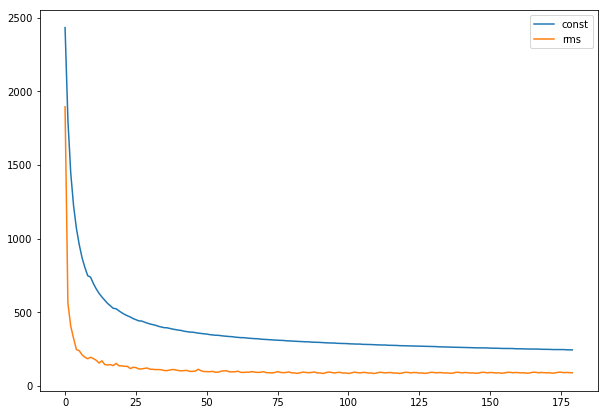

In [15]:
pY, _ = forward(Xtest, W1, b1, W2, b2)
print("Final error rate:", error_rate(pY, Ytest))

%matplotlib inline
plt.figure(figsize = (10,7))
plt.plot(LL_batch, label='const')
plt.plot(LL_rms, label='rms')
plt.legend()
plt.show()